## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

from numpy.linalg import norm

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","green"])

In [3]:
np.random.seed(0)

## Generate data

In [4]:
from sklearn.datasets import  make_circles

In [5]:
data, labels = make_circles(n_samples=1000, random_state=0, noise=0.2, factor=0.3)
print(data.shape, labels.shape)

(1000, 2) (1000,)


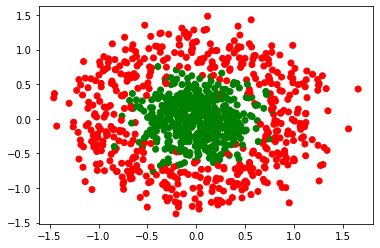

In [6]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [7]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

## Multi class classification

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0,test_size=0.2)
print(X_train.shape, X_val.shape, labels.shape)

(800, 2) (200, 2) (1000,)


In [9]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(800, 2) (200, 2)


In [10]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,2)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721]]


## FF Class

In [11]:
class FFNetwork:
  
  def __init__(self, W1, W2):
        
    self.params={}
    self.params["W1"]=W1.copy()
    self.params["W2"]=W2.copy()
    self.params["B1"]=np.zeros((1,2))
    self.params["B2"]=np.zeros((1,2))
    self.num_layers=2
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    return 1.0/(1.0 + np.exp(-X))
      
  def grad_activation(self, X):
    return X*(1-X) 

  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
      
    if display_loss:
      loss = {}
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      if algo == "GD":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
            
      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
          
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
      if display_loss:
        Y_pred = self.predict(X)
        loss[num_epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    if display_loss:
      plt.plot(loss.values(), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [12]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

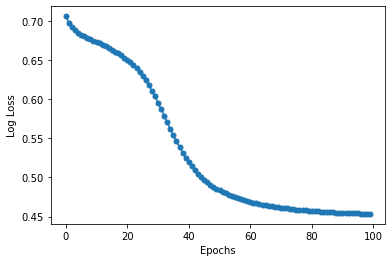

Training accuracy 0.8012
Validation accuracy 0.785
Wall time: 681 ms


In [13]:

%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/10 [00:00<?, ?epoch/s]

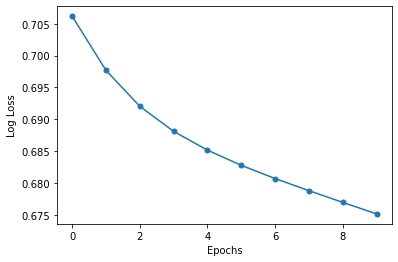

Training accuracy 0.645
Validation accuracy 0.62


In [14]:
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=10, eta=1,algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

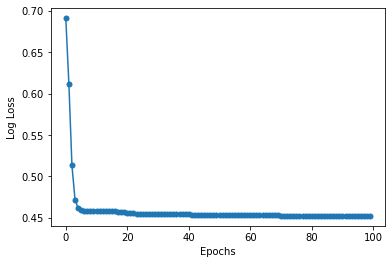

Training accuracy 0.79
Validation accuracy 0.795
Wall time: 1.97 s


In [15]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=8, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

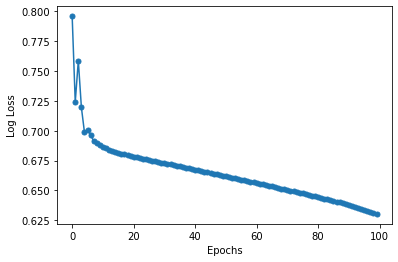

Training accuracy 0.6438
Validation accuracy 0.62
Wall time: 571 ms


In [16]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.5, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

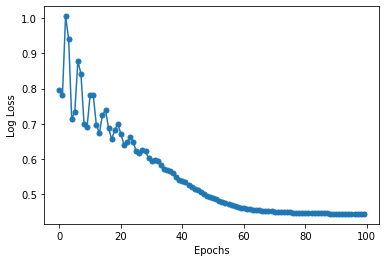

Training accuracy 0.7887
Validation accuracy 0.79
Wall time: 563 ms


In [17]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

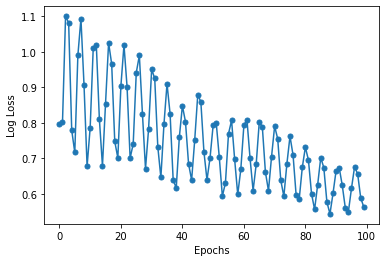

Training accuracy 0.7388
Validation accuracy 0.705
Wall time: 512 ms


In [18]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.99, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

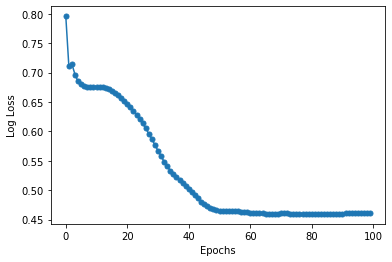

Training accuracy 0.78
Validation accuracy 0.775
Wall time: 426 ms


In [19]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.99, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

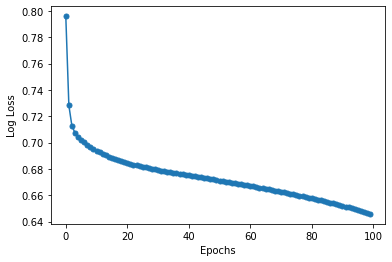

Training accuracy 0.6262
Validation accuracy 0.6
Wall time: 492 ms


In [20]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.5, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

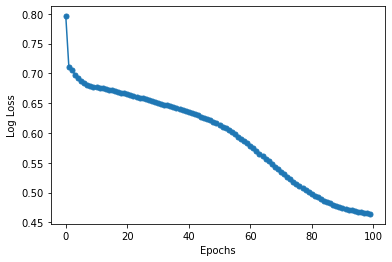

Training accuracy 0.7988
Validation accuracy 0.79
Wall time: 586 ms


In [21]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

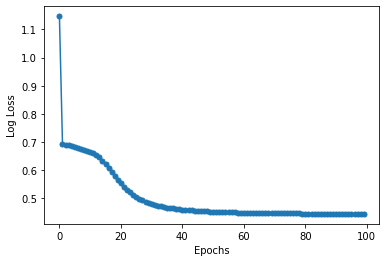

Training accuracy 0.8038
Validation accuracy 0.775
Wall time: 397 ms


In [22]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

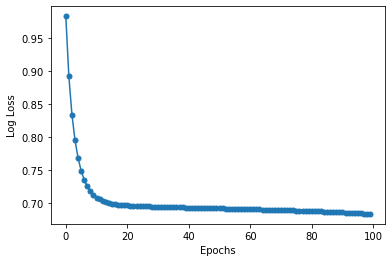

Training accuracy 0.5712
Validation accuracy 0.525
Wall time: 467 ms


In [23]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

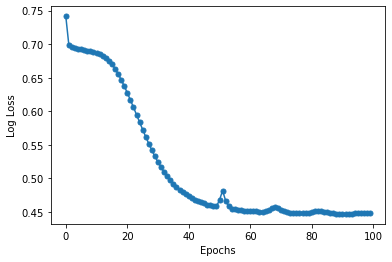

Training accuracy 0.8025
Validation accuracy 0.76
Wall time: 439 ms


In [24]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

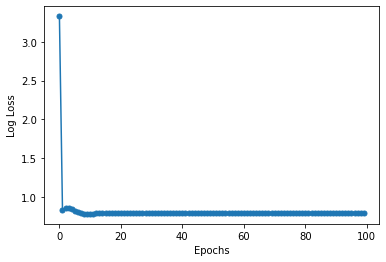

Training accuracy 0.5
Validation accuracy 0.5
Wall time: 465 ms


In [25]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

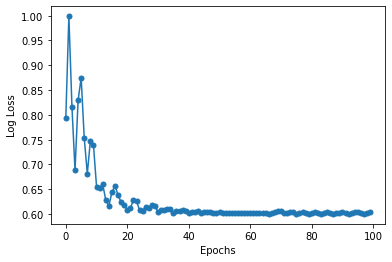

Training accuracy 0.6362
Validation accuracy 0.69
Wall time: 512 ms


In [26]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

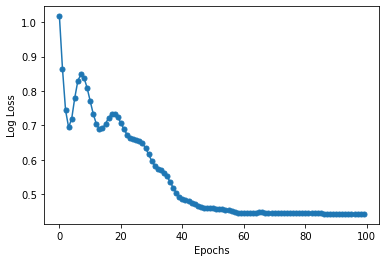

Training accuracy 0.8012
Validation accuracy 0.77
Wall time: 535 ms


In [27]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

## Good configurations with each algo

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

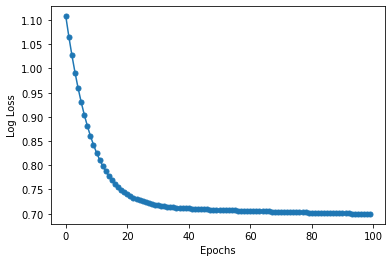

Training accuracy 0.5512
Validation accuracy 0.51
Wall time: 390 ms


In [28]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=0.1, algo="GD", display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

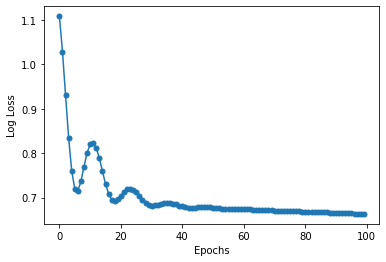

Training accuracy 0.5925
Validation accuracy 0.56
Wall time: 445 ms


In [29]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=0.1, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

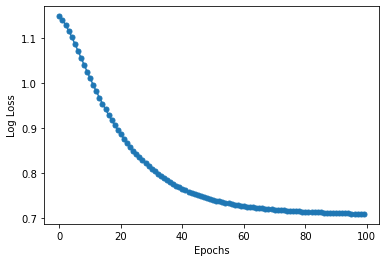

Training accuracy 0.4988
Validation accuracy 0.475
Wall time: 454 ms


In [30]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=0.1, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

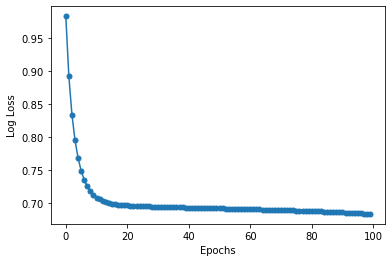

Training accuracy 0.5712
Validation accuracy 0.525
Wall time: 428 ms


In [31]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

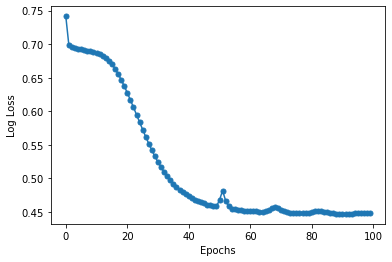

Training accuracy 0.8025
Validation accuracy 0.76
Wall time: 410 ms


In [32]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

## Adam with 100 epochs can be a good configuration

C:\Users\USER\AppData\Local\Temp/ipykernel_11800/449384262.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

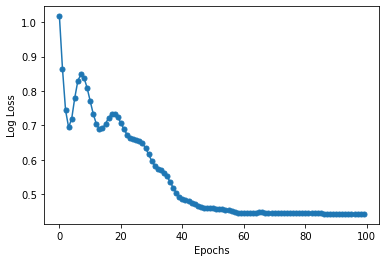

Training accuracy 0.8012
Validation accuracy 0.77
Wall time: 489 ms


In [33]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()